# BOS Velocimetry with OpenPIV and PIVPy


PIV - particle image velocimetry 
BOS - background oriented schlieren

Data credit: Gary Settles, PSU

OpenPIV part credit: Alex Liberzon, TAU



# Steps

There are several steps:

1. multi-grid window deformation PIV run on the tare image and two jet images: 0, 1, the output is a TXT file in the form of x,y,u,v,...
2. read the TXT file using PIVPy and create two images of scalar fields (alike images), using the streamwise displacement component, or displacement gradients, the output is two "scalar" images
3. another, multi-grid window deformation PIV run on the two "scalar" images creates a velocity field, stored in TXT file that we can immediately append to the DataSet

The run of steps 1-3 is rather long, but it saves a lot of data writing/reading. We could also save time by removing the need for TXT files, but it will require some tweaking with the windef function. 

In [2]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv,pivpy

ModuleNotFoundError: No module named 'watermark'

In [ ]:
from openpiv import windef
from openpiv import tools, pyprocess, scaling, validation, filters, preprocess
import numpy as np
import os, glob
from time import time
import warnings


from pivpy import io, pivpy, graphics
import xarray as xr
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

From tare image and two jet BOS images create two displacement fields

In [ ]:
# parameter settings - the location of the root folder
root_folder = '../data'

In [ ]:
# base folder is the experimental name
base_folder = '20210420-Run1'

In [ ]:
from openpiv.tools import imread, Multiprocesser, display_vector_field, \
    transform_coordinates
from openpiv import validation, filters, tools, preprocess, scaling, tools
from openpiv.pyprocess import extended_search_area_piv, get_coordinates, \
    get_field_shape
from openpiv import smoothn
from skimage.measure import points_in_poly
from skimage.util import invert

from openpiv.windef import first_pass, multipass_img_deform

In [ ]:
def piv_run(frame_a, frame_b, settings, counter=0):
    # "first pass"
    x, y, u, v, s2n = first_pass(
        frame_a,
        frame_b,
        settings
    )

    if settings.show_all_plots:
        plt.figure()
        plt.quiver(x,y,u,-v,color='b')
        # plt.gca().invert_yaxis()
        # plt.gca().set_aspect(1.)
        # plt.title('after first pass, invert')
        # plt.show()

    # " Image masking "
    if settings.image_mask:
        image_mask = np.logical_and(mask_a, mask_b)
        mask_coords = preprocess.mask_coordinates(image_mask)
        # mark those points on the grid of PIV inside the mask
        grid_mask = preprocess.prepare_mask_on_grid(x,y,mask_coords)

        # mask the velocity
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        mask_coords = []
        u = np.ma.masked_array(u, mask=np.ma.nomask)
        v = np.ma.masked_array(v, mask=np.ma.nomask)

    if settings.validation_first_pass:
        u, v, mask = validation.typical_validation(u, v, s2n, settings)

    if settings.show_all_plots:
        plt.figure()
        plt.quiver(x,y,u,-v,color='r')
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(1.)
        plt.title('after first pass validation new, inverted')
        plt.show()


    # "filter to replace the values that where marked by the validation"
    if settings.num_iterations == 1 and settings.replace_vectors:
        # for multi-pass we cannot have holes in the data
        # after the first pass
        u, v = filters.replace_outliers(
            u,
            v,
            method=settings.filter_method,
            max_iter=settings.max_filter_iteration,
            kernel_size=settings.filter_kernel_size,
        )
    elif settings.num_iterations > 1: # don't even check if it's true or false
        u, v = filters.replace_outliers(
            u,
            v,
            method=settings.filter_method,
            max_iter=settings.max_filter_iteration,
            kernel_size=settings.filter_kernel_size,
        )

        # "adding masks to add the effect of all the validations"
    if settings.smoothn:
        u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
            u, s=settings.smoothn_p
        )
        v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
            v, s=settings.smoothn_p
        )

    if settings.image_mask:
        grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        u = np.ma.masked_array(u, np.ma.nomask)
        v = np.ma.masked_array(v, np.ma.nomask)


    if settings.show_all_plots:
        plt.figure()
        plt.quiver(x,y,u,-v)
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(1.)
        plt.title('before multi pass, inverted')
        plt.show()

    if not isinstance(u, np.ma.MaskedArray):
        raise ValueError("Expected masked array")

    """ Multi pass """

    for i in range(1, settings.num_iterations):

        if not isinstance(u, np.ma.MaskedArray):
            raise ValueError("Expected masked array")

        x, y, u, v, s2n, mask = multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings,
            mask_coords=mask_coords
        )        

        # If the smoothing is active, we do it at each pass
        # but not the last one
        if settings.smoothn is True and i < settings.num_iterations-1: 
            u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
                u, s=settings.smoothn_p
            )
            v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
                v, s=settings.smoothn_p
            )
        if not isinstance(u, np.ma.MaskedArray):
            raise ValueError ('not a masked array anymore')

        if hasattr(settings, 'image_mask') and settings.image_mask:
            grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
            u = np.ma.masked_array(u, mask=grid_mask)
            v = np.ma.masked_array(v, mask=grid_mask)
        else:
            u = np.ma.masked_array(u, np.ma.nomask)
            v = np.ma.masked_array(v, np.ma.nomask)

        if settings.show_all_plots:
            plt.figure()
            plt.quiver(x, y, u, -v, color='r')
            plt.gca().set_aspect(1.)
            plt.gca().invert_yaxis()
            plt.title('end of the multipass, invert')
            plt.show()

    if settings.show_all_plots and settings.num_iterations > 1:
        plt.figure()
        plt.quiver(x,y,u,-v)
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(1.)
        plt.title('after multi pass, before saving, inverted')
        plt.show()

    # we now use only 0s instead of the image
    # masked regions. 
    # we could do Nan, not sure what is best
    u = u.filled(0.)
    v = v.filled(0.)

    # "scales the results pixel-> meter"
    x, y, u, v = scaling.uniform(x, y, u, v,
                                 scaling_factor=settings.scaling_factor)

    if settings.image_mask:
        grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        u = np.ma.masked_array(u, np.ma.nomask)
        v = np.ma.masked_array(v, np.ma.nomask)

    # before saving we conver to the "physically relevant"
    # right-hand coordinate system with 0,0 at the bottom left
    # x to the right, y upwards
    # and so u,v

    x, y, u, v = transform_coordinates(x, y, u, v)
    # import pdb; pdb.set_trace()
    # "save to a file"
    tools.save(x, y, u, v, mask,
        os.path.join(settings.save_path, "field_A%03d.txt" % counter),
        delimiter="\t",
    )
    
        # "some other stuff that one might want to use"
    if settings.show_plot or settings.save_plot:
        Name = os.path.join(settings.save_path, "Image_A%03d.png" % counter)
        fig, _ = display_vector_field(
            os.path.join(settings.save_path, "field_A%03d.txt" % counter),
            scale=settings.scale_plot,
        )
        if settings.save_plot is True:
            fig.savefig(Name)
        if settings.show_plot is True:
            plt.show()



In [ ]:
# def func(args):
def piv(settings, counter=0):
    """A function to process each image pair."""

    # this line is REQUIRED for multiprocessing to work
    # always use it in your custom function
    
    # file_a, file_b, counter = args

    
    
    file_a = os.path.join(settings.filepath_images, settings.frame_pattern_a)
    file_b = os.path.join(settings.filepath_images, settings.frame_pattern_b)
    print(file_a)

    # read images into numpy arrays
    frame_a = imread(file_a)
    frame_b = imread(file_b)

    " crop to ROI"
    if settings.ROI == "full":
        frame_a = frame_a
        frame_b = frame_b
    else:
        frame_a = frame_a[
            settings.ROI[0]:settings.ROI[1],
            settings.ROI[2]:settings.ROI[3]
        ]
        frame_b = frame_b[
            settings.ROI[0]:settings.ROI[1],
            settings.ROI[2]:settings.ROI[3]
        ]

    if settings.invert is True:
        frame_a = invert(frame_a)
        frame_b = invert(frame_b)

    if settings.show_all_plots:
        fig, ax = plt.subplots(1,1)
        ax.imshow(frame_a, cmap=plt.get_cmap('Reds'))
        ax.imshow(frame_b, cmap=plt.get_cmap('Blues'),alpha=.5)
        plt.show()

    if settings.dynamic_masking_method in ("edge", "intensity"):
        frame_a, mask_a = preprocess.dynamic_masking(
            frame_a,
            method=settings.dynamic_masking_method,
            filter_size=settings.dynamic_masking_filter_size,
            threshold=settings.dynamic_masking_threshold,
        )
        frame_b, mask_b = preprocess.dynamic_masking(
            frame_b,
            method=settings.dynamic_masking_method,
            filter_size=settings.dynamic_masking_filter_size,
            threshold=settings.dynamic_masking_threshold,
        )

    piv_run(frame_a, frame_b, settings)
    
    print(f"Image Pair {counter + 1}")
    print(file_a.rsplit('/')[-1],file_b.rsplit('/')[-1])




# def piv(settings):
#     """ the func fuction is the "frame" in which the PIV evaluation is done """

#     # "Below is code to read files and create a folder to store the results"
#     save_path = os.path.join(
#         settings.save_path,
#         "Open_PIV_results_"
#         + str(settings.windowsizes[settings.num_iterations-1])
#         + "_"
#         + settings.save_folder_suffix,
#     )
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     task = Multiprocesser(
#         data_dir=settings.filepath_images,
#         pattern_a=settings.frame_pattern_a,
#         pattern_b=settings.frame_pattern_b,
#     )
#     task.run(func=func, n_cpus=1)

In [ ]:
settings = windef.Settings()


'Data related settings'
# Folder with the images to process
settings.filepath_images = f'{root_folder}/{base_folder}'
settings.save_path = f'{root_folder}/results_{base_folder}'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Run1'
# Format and Image Sequence
settings.frame_pattern_b = '20210420-tare1000001.tif'
# settings.frame_pattern_a = '20210420-Run1000023.tif'


'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
# settings.ROI = (100,400,600,1024)
# settings.ROI = [0,980,320,700]
settings.ROI = 'full'

settings.deformation_method = 'symmetric' 
# settings.deformation_method = 'second image'


settings.num_iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 8)
settings.overlap=(32, 16, 8, 4)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)

# 'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_threshold = 1.0
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
settings.sig2noise_validate = False

# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = False
settings.scale_plot = 20  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
# settings.normalized_correlation = True

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True

settings.replace_vectors = True

settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 2
settings.filter_kernel_size = 1  # kernel size for the localmean method



settings.MinMax_U_disp = (-10, 10)
settings.MinMax_V_disp = (-10, 10)

# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 5  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size = 2 # defines the size of the local median, it'll be 3 x 3

# New settings for version 0.23.2c
settings.image_mask = False

# Image mask properties
settings.dynamic_masking_method = None
# settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21



# Smoothing after the first pass
settings.smoothn = True #Enables smoothing of the displacemenet field
settings.smoothn_p = 0.05 # This is a smoothing parameter


settings.show_all_plots = False

settings.invert = False

#settings.remove_mean_shift = False


# "Below is code to read files and create a folder to store the results"
settings.save_path = os.path.join(
    settings.save_path,
    "Open_PIV_results_"
    + str(settings.windowsizes[settings.num_iterations-1])
    + "_"
    + settings.save_folder_suffix,
)
if not os.path.exists(settings.save_path):
    os.makedirs(settings.save_path)

In [ ]:
# pair 1
settings.frame_pattern_a = '20210420-Run1000023.tif'
piv(settings)

../data/20210420-Run1/20210420-Run1000023.tif
Image Pair 1
20210420-Run1000023.tif 20210420-tare1000001.tif


In [ ]:
res_file = os.path.join(settings.save_path,'field_A000.txt')
# os.path.exists(res_file)
d0 = io.load_txt(res_file)

In [ ]:
settings.frame_pattern_a = '20210420-Run1000024.tif'
piv(settings)

../data/20210420-Run1/20210420-Run1000024.tif
Image Pair 1
20210420-Run1000024.tif 20210420-tare1000001.tif


In [ ]:
d1 = io.load_txt(res_file)

From TXT file to the streamwise component of displacement image

In [ ]:
def save_figure_to_numpy(fig):
    # save it to a numpy array.
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data #.transpose(2, 0, 1)

In [ ]:
# prepare strain-like scalar field
d0.piv.strain()
d1.piv.strain()

<xarray.Dataset>
Dimensions:  (x: 255, y: 127, t: 1)
Coordinates:
  * x        (x) float64 4.0 8.0 12.0 16.0 ... 1.012e+03 1.016e+03 1.02e+03
  * y        (y) float64 508.0 504.0 500.0 496.0 492.0 ... 16.0 12.0 8.0 4.0
  * t        (t) int64 0
Data variables:
    u        (x, y, t) float64 0.0443 0.0144 0.0244 ... -0.0221 -0.015 -0.0062
    v        (x, y, t) float64 0.0175 0.0077 0.0085 ... 0.0554 0.064 0.0763
    chc      (x, y, t) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    w        (x, y, t) float64 9.603e-05 2.216e-05 ... 1.44e-05 9.869e-06
Attributes:
    variables:  ['x', 'strain', 'u', 'v', 's2n', 'strain']
    units:      ['pix', 'pix', 'pix/dt', 'pix/dt', '1/dt']
    dt:         1.0
    files:      ../data/results_20210420-Run1/Open_PIV_results_8_Run1/field_A...

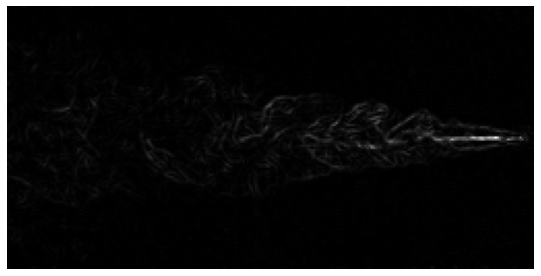

In [ ]:
fig, ax = plt.subplots()
# ax.imshow(d0.isel(t=0)['u'].T,cmap=plt.cm.gray) 
ax.imshow(d0.isel(t=0)['w'].T,cmap=plt.cm.gray) 
fig.tight_layout()
ax.axis('off')
fig.canvas.draw()
frame_a = save_figure_to_numpy(fig)

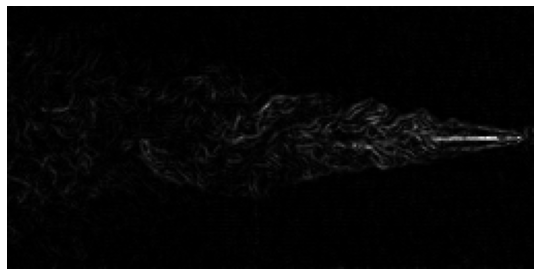

In [ ]:
# from matplotlib.backends.backend_agg import FigureCanvasAgg

fig, ax = plt.subplots()
# ax.imshow(d1.isel(t=0)['u'].T,cmap=plt.cm.gray)
ax.imshow(d1.isel(t=0)['w'].T,cmap=plt.cm.gray)
fig.tight_layout()
ax.axis('off')
fig.canvas.draw()
frame_b = save_figure_to_numpy(fig)

# plt.figure()
# plt.imshow(img)


In [ ]:
# let's try to avoid imshow
# d0.piv.strain()
# tmp = d0.fillna(0)
# tmp = tmp.isel(t=0)['w'].T.values
# tmp = tmp.squeeze()
# tmp = (tmp - tmp.min())/(tmp.max() - tmp.min())
# frame_a = (tmp*255).astype(np.int32)

# tmp = d1.fillna(0)
# tmp = tmp.isel(t=0)['w'].T.values
# tmp = tmp.squeeze()
# tmp = (tmp - tmp.min())/(tmp.max() - tmp.min())
# frame_b = (tmp*255).astype(np.int32)

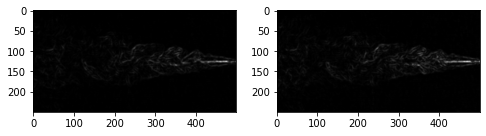

In [ ]:
fig, ax = plt.subplots(1,2)

# crop images
frame_a = np.mean(frame_a[90:340,50:550],axis=2)
frame_b = np.mean(frame_b[90:340,50:550],axis=2)

ax[0].imshow(frame_a, cmap='gray')
ax[1].imshow(frame_b, cmap='gray')

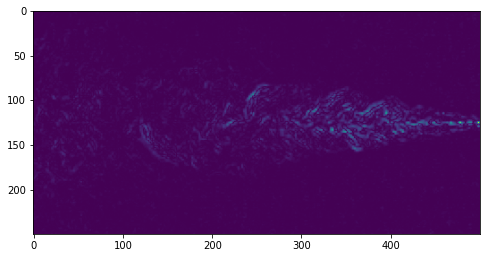

In [ ]:
plt.imshow(np.abs(frame_a - frame_b))

In [ ]:
settings.show_all_plots = False
settings.invert = True
# settings.ROI = [100,350,50,550]
settings.ROI = 'full'

piv_run(frame_a, frame_b, settings)

TXT to DataSet

In [ ]:
res_file = os.path.join(settings.save_path,'field_A000.txt')
os.path.exists(res_file)

True

In [ ]:
d2 = io.load_txt(res_file)

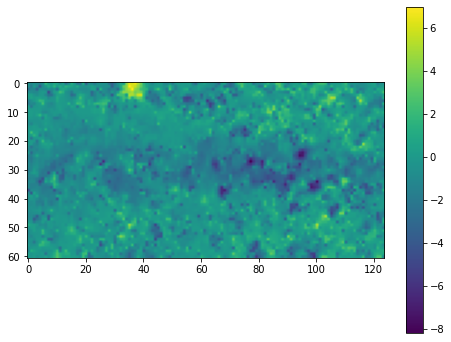

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(d2.isel(t=0)['u'].T)
plt.colorbar(im)

# fig.tight_layout()
# ax.axis('off')
# fig.canvas.draw()
# frame_a = save_figure_to_numpy(fig)

Text(0, 0.5, 'Centerline velocity distribution (pix/dt)')

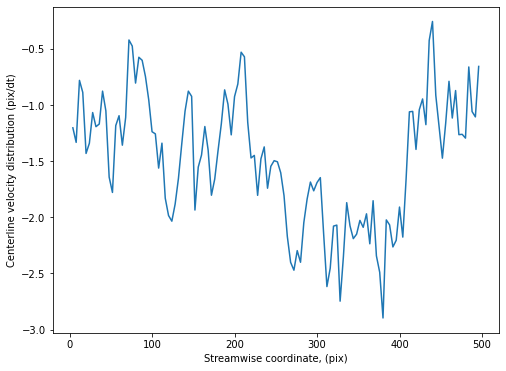

In [ ]:
plt.plot(d2.x,np.mean(d2['u'][:,20:40,0],axis=1));
plt.xlabel('Streamwise coordinate, (pix)')
plt.ylabel('Centerline velocity distribution (pix/dt)')

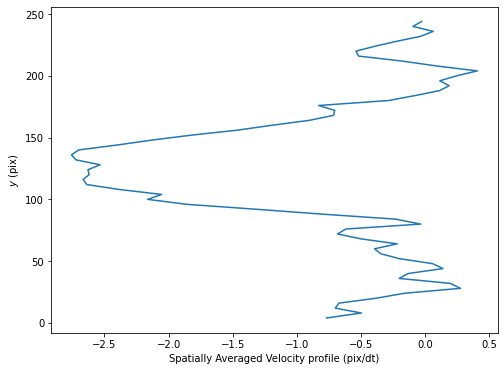

In [ ]:
plt.plot(np.mean(d2['u'][60:100,:,0],axis=0),d2.y);
plt.ylabel('$y$ (pix)')
plt.xlabel('Spatially Averaged Velocity profile (pix/dt)');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a409ffc-4365-43ea-9d49-425c249ee983' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>